## 1. Project Overview

This project aims to leverage data-driven insights to enhance fan engagement and support monetization strategies for VeloCityX. Specifically, we will analyze user interaction data to understand fan behavior and provide actionable recommendations. These insights will be used to optimize fan challenges, increase merchandise sales, and improve sponsorship integration, ultimately driving growth and enriching the overall spectator experienc。

## 2. Data Collection

The data has been collected in a CSV file, which includes sample data on user interactions within the VeloCityX app. <br>
This data includes details like: 
* User ID
* Fan challenges completed 
* Predictive accuracy in challenges 
* Virtual merchandise purchases 
* Sponsorship interactions (ad views, click-through rates) 
* Time spent on "Live 360" coverage 
* Real-time chat activity 

## 3. Data Cleaning

To ensure the accuracy and reliability of the analysis, the dataset will undergo a thorough data cleaning process.

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import GridSearchCV

In [220]:
# Load the CSV file
file_path = './2025-VeloCityX-Expanded-Fan-Engagement-Data.csv'
velocityx_data = pd.read_csv(file_path)

In [222]:
#check missing values
missing_values = velocityx_data.isnull().sum()
print("Missing Values:\n", missing_values.to_string())

Missing Values:
 User ID                                    0
Fan Challenges Completed                   0
Predictive Accuracy (%)                    0
Virtual Merchandise Purchases              0
Sponsorship Interactions (Ad Clicks)       0
Time on Live 360 (mins)                    0
Real-Time Chat Activity (Messages Sent)    0


In [224]:
# Check for duplicate User IDs
duplicate_user_ids = velocityx_data[velocityx_data.duplicated(subset='User ID', keep=False)]

# Display the duplicated User ID rows, if any
if not duplicate_user_ids.empty:
    print("Duplicate User IDs found:")
    print(duplicate_user_ids)
else:
    print("No duplicate User IDs found.")

No duplicate User IDs found.


In [226]:
# Define a function to identify outliers based on the IQR method
def identify_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

# Check for outliers in each numeric column and display the results
numeric_columns = velocityx_data.select_dtypes(include=['float64', 'int64']).columns

for column in numeric_columns:
    outliers = identify_outliers(velocityx_data, column)
    if not outliers.empty:
        print(f"Outliers detected in '{column}':")
        print(outliers)
    else:
        print(f"No outliers detected in '{column}'.")

No outliers detected in 'Fan Challenges Completed'.
No outliers detected in 'Predictive Accuracy (%)'.
No outliers detected in 'Virtual Merchandise Purchases'.
No outliers detected in 'Sponsorship Interactions (Ad Clicks)'.
No outliers detected in 'Time on Live 360 (mins)'.
No outliers detected in 'Real-Time Chat Activity (Messages Sent)'.


Since there are no missing values, no duplicate users, and no outliers in any of the variables, the dataset is ready for direct analysis and visualization. As a result, there is no need for data imputation or cleaning steps related to missing values, duplicates, or outliers.

## 4. Data Exploration and Visualization

### Overall Observations

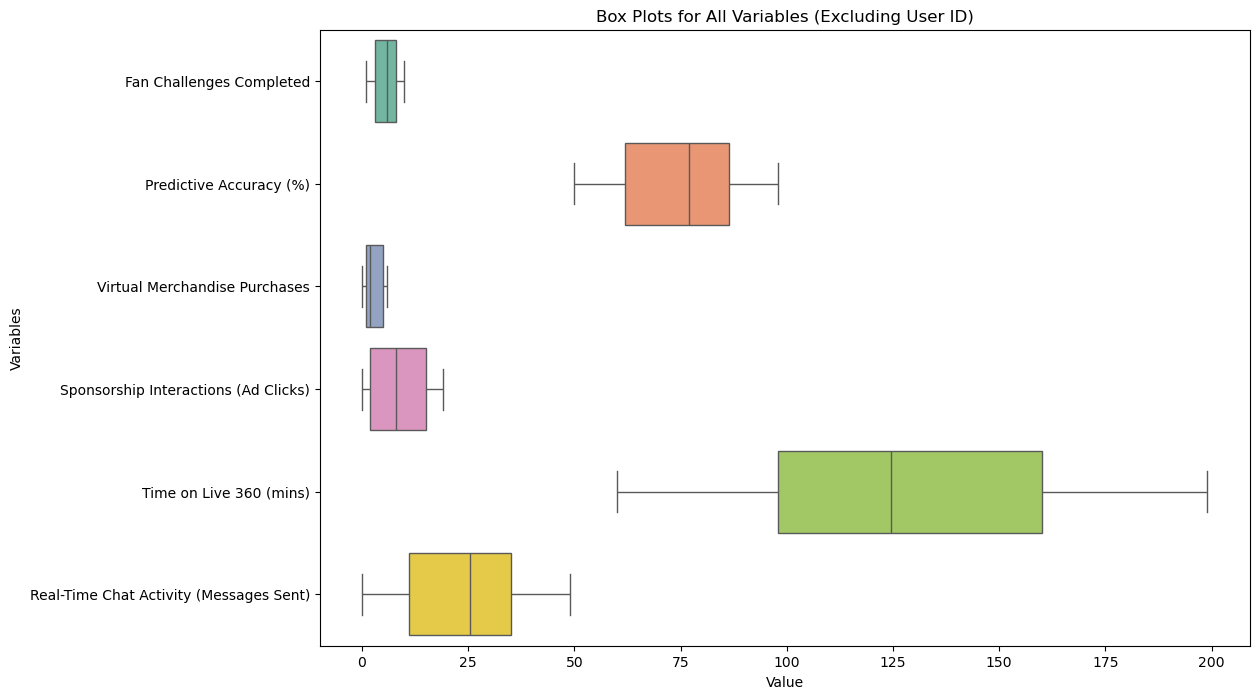

In [230]:
# Drop the 'User ID' column, as it is not needed for box plots
data_to_plot = velocityx_data.drop(columns=['User ID'])

# Set up the figure and axes
plt.figure(figsize=(12, 8))

# Create box plots for each variable
sns.boxplot(data=data_to_plot, orient='h', palette='Set2')

# Add title and labels
plt.title('Box Plots for All Variables (Excluding User ID)')
plt.xlabel('Value')
plt.ylabel('Variables')

# Display the plot
plt.show()

Based on the box plots, we can find that:
* **Time on Live 360:** This variable has the widest range, indicating that user engagement with live coverage is highly variable, with some users showing far greater participation than others.
* **Virtual Merchandise Purchases and Sponsorship Interactions:** These variables show lower engagement overall, as the upper bounds for both are relatively modest compared to other metrics.
* **Fan Challenges Completed and Predictive Accuracy:** These variables show more consistency among users, with moderate to high engagement levels and no extreme outliers.

While most users show moderate to high engagement with challenges and predictive accuracy, their engagement with ads and merchandise is lower. The time spent on Live 360 shows the widest variability, which could indicate that only a subset of users are highly engaged with live event coverage.

### Correlation

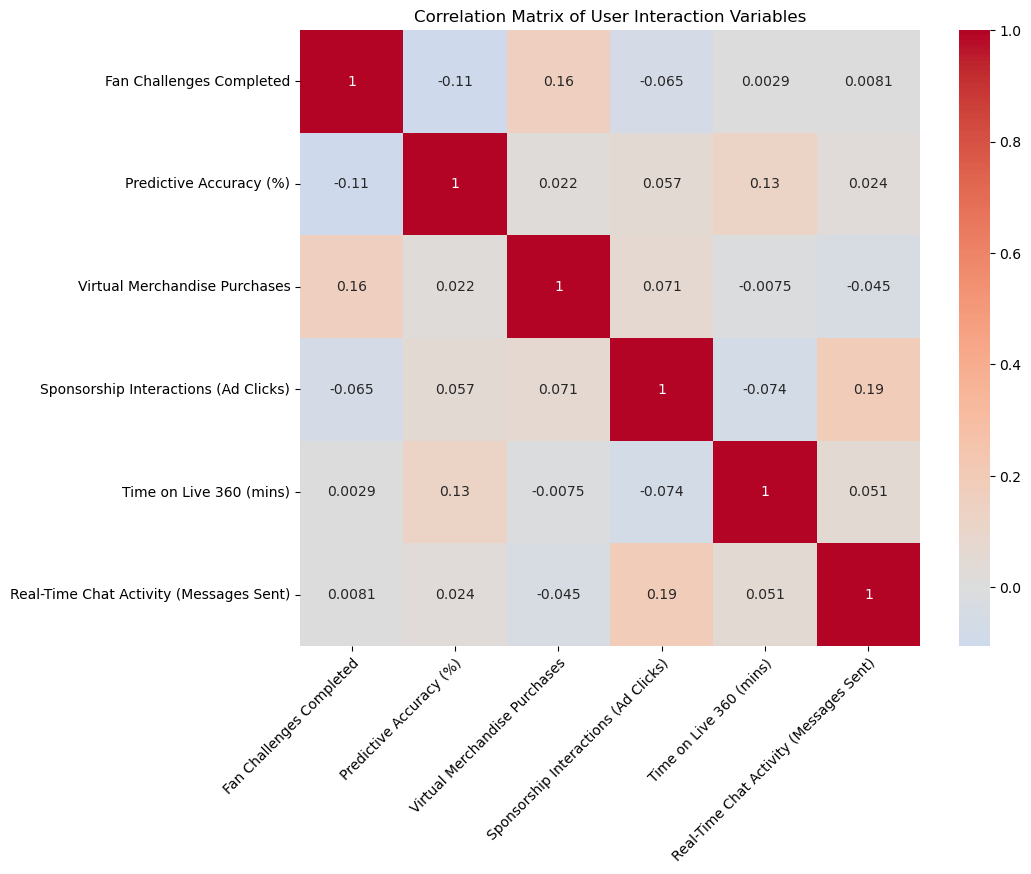

In [41]:
# Correlation Matrix
correlation_matrix = velocityx_data.drop(columns='User ID').corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Add title and adjust x-axis label positions
plt.title('Correlation Matrix of User Interaction Variables')
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')  # Rotate and align to center of the cell
plt.yticks(rotation=0)

# Adjust the alignment of x-axis labels to move them slightly left or right
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('right')
    tick.set_rotation_mode('anchor')

plt.show()



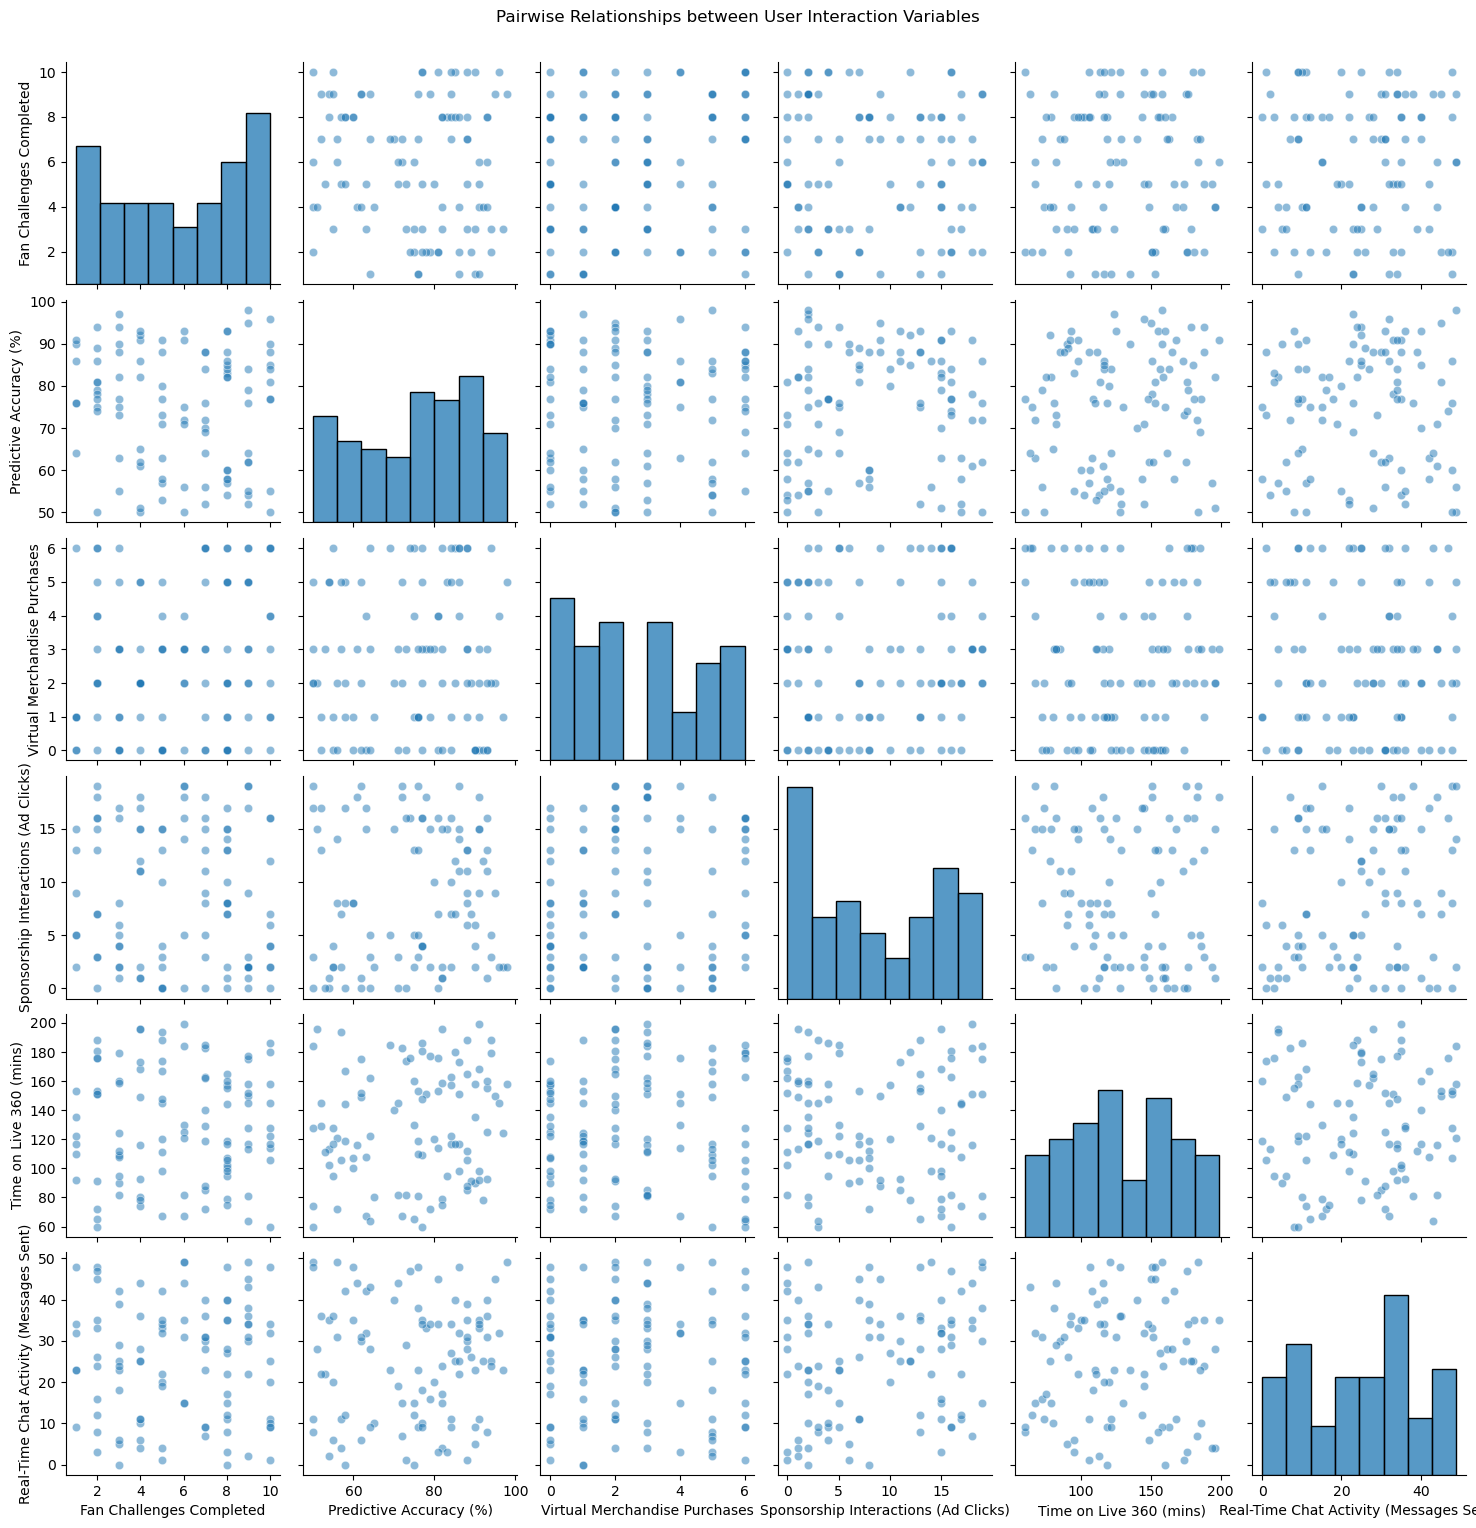

In [77]:
# Drop the 'User ID' column as it is not needed for pairwise correlation visualization
data_for_plot = velocityx_data.drop(columns='User ID')

# Create a smaller pairplot to visualize relationships between variables
sns.pairplot(data_for_plot, kind='scatter', diag_kind='hist', plot_kws={'alpha': 0.5}, height=2.5, aspect=1)
plt.suptitle('Pairwise Relationships between User Interaction Variables', y=1.02)
plt.show()

Based on the correlation matrix and the pairplot matrix, we can find that:
> **Insights from histograms:**
>> * The histograms on the diagonal reveal that users who complete all challenges are the most common.
>> * Most users also have a high predictive accuracy percentage.
>> * Relatively few purchase large quantities of virtual merchandise or engage heavily in sponsorship interactions.
>> * The distribution of users who watch Live 360 closely mirrors those who participate in real-time chat, with a higher concentration of users around the middle values, and fewer users at the extremes (lowest and highest levels of engagement).<br>

> **Insights from correlation matrix and scatter plots:**
>> Most variables exhibit weak correlations with one another, suggesting that user activities are largely independent.However, some notable relationships include:
>> *  A slight positive correlation between Sponsorship Interactions and Real-Time Chat Activity.
>> *  A weak positive correlation between Virtual Merchandise Purchases and Fan Challenges Completed.
>> *  A slight positive correlation between predictive accuracy and the amount of time users spend watching Live 360.

## 5. Statistical Significance

In [152]:
# Define the pairs of variables for hypothesis testing
variable_pairs = [
    ("Sponsorship Interactions (Ad Clicks)", "Real-Time Chat Activity (Messages Sent)"),
    ("Virtual Merchandise Purchases", "Fan Challenges Completed"),
    ("Predictive Accuracy (%)", "Time on Live 360 (mins)")
]

# Perform hypothesis testing for each pair
for var1, var2 in variable_pairs:
    # Calculate Pearson correlation and p-value
    correlation, p_value = pearsonr(data_to_standardize[var1], data_to_standardize[var2])
    # Print the results
    print(f"Correlation between {var1} and {var2}:")
    print(f"  Correlation coefficient: {correlation:.4f}")
    print(f"  P-value: {p_value:.4f}")
    
    # Interpret the p-value
    if p_value < 0.1:
        print(f"  The correlation is statistically significant (p < 0.1).\n")
    else:
        print(f"  The correlation is not statistically significant (p >= 0.1).\n")

Correlation between Sponsorship Interactions (Ad Clicks) and Real-Time Chat Activity (Messages Sent):
  Correlation coefficient: 0.1913
  P-value: 0.0566
  The correlation is statistically significant (p < 0.1).

Correlation between Virtual Merchandise Purchases and Fan Challenges Completed:
  Correlation coefficient: 0.1594
  P-value: 0.1132
  The correlation is not statistically significant (p >= 0.1).

Correlation between Predictive Accuracy (%) and Time on Live 360 (mins):
  Correlation coefficient: 0.1254
  P-value: 0.2137
  The correlation is not statistically significant (p >= 0.1).



 For ad interactions and chat activity,there is a statistically significant correlation. It implies an opportunity to optimize ad placements within chat features or offer rewards for viewing ads within chat environments.<br>
 For Merchandise and Challenges, though there is a weak relationship, it is not statistically significant. Thus, direct incentives for purchases might be more effective than increasing challenge completion.<br>
 For Predictive Accuracy and Live 360 Time, the lack of a significant relationship suggests that improving predictive accuracy may not be effectively achieved through increased viewing time. Consider providing tailored content or predictive tips instead.

## 6. Cluster

According to the data visualization and statistical significance test, there are no very obvious relationships between the variables. Therefore, the dataset will be standardized and clustered to uncover any underlying patterns or relationships.

In [155]:
# Drop 'User ID' column, since it's categorical and doesn't need standardization
data_to_standardize = velocityx_data.drop(columns=['User ID'])

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the data
standardized_data = scaler.fit_transform(data_to_standardize)

# Convert the standardized data back into a DataFrame with the original column names
standardized_df = pd.DataFrame(standardized_data, columns=data_to_standardize.columns)

# save the standardized data to a new CSV file
standardized_df.to_csv('standardized_velocityx_data.csv', index=False)

# Display the first few rows of the standardized data
print("Standardized Data:")
print(standardized_df.head())

Standardized Data:
   Fan Challenges Completed  Predictive Accuracy (%)  \
0                 -0.280964                 0.358801   
1                  0.785989                -1.073539   
2                 -0.992267                 1.074971   
3                  0.430338                -0.357369   
4                 -1.347918                -1.789709   

   Virtual Merchandise Purchases  Sponsorship Interactions (Ad Clicks)  \
0                       0.160621                              0.209240   
1                      -0.812837                             -0.107790   
2                      -1.299566                             -0.424821   
3                      -0.326108                              1.001818   
4                       1.134078                             -0.900368   

   Time on Live 360 (mins)  Real-Time Chat Activity (Messages Sent)   Cluster  
0                -0.243232                                -0.358357 -0.035626  
1                -0.763514             

C:\Users\chen4469\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Clustered Data:
   Fan Challenges Completed  Predictive Accuracy (%)  \
0                 -0.280964                 0.358801   
1                  0.785989                -1.073539   
2                 -0.992267                 1.074971   
3                  0.430338                -0.357369   
4                 -1.347918                -1.789709   

   Virtual Merchandise Purchases  Sponsorship Interactions (Ad Clicks)  \
0                       0.160621                              0.209240   
1                      -0.812837                             -0.107790   
2                      -1.299566                             -0.424821   
3                      -0.326108                              1.001818   
4                       1.134078                             -0.900368   

   Time on Live 360 (mins)  Real-Time Chat Activity (Messages Sent)  Cluster  
0                -0.243232                                -0.358357        1  
1                -0.763514                  

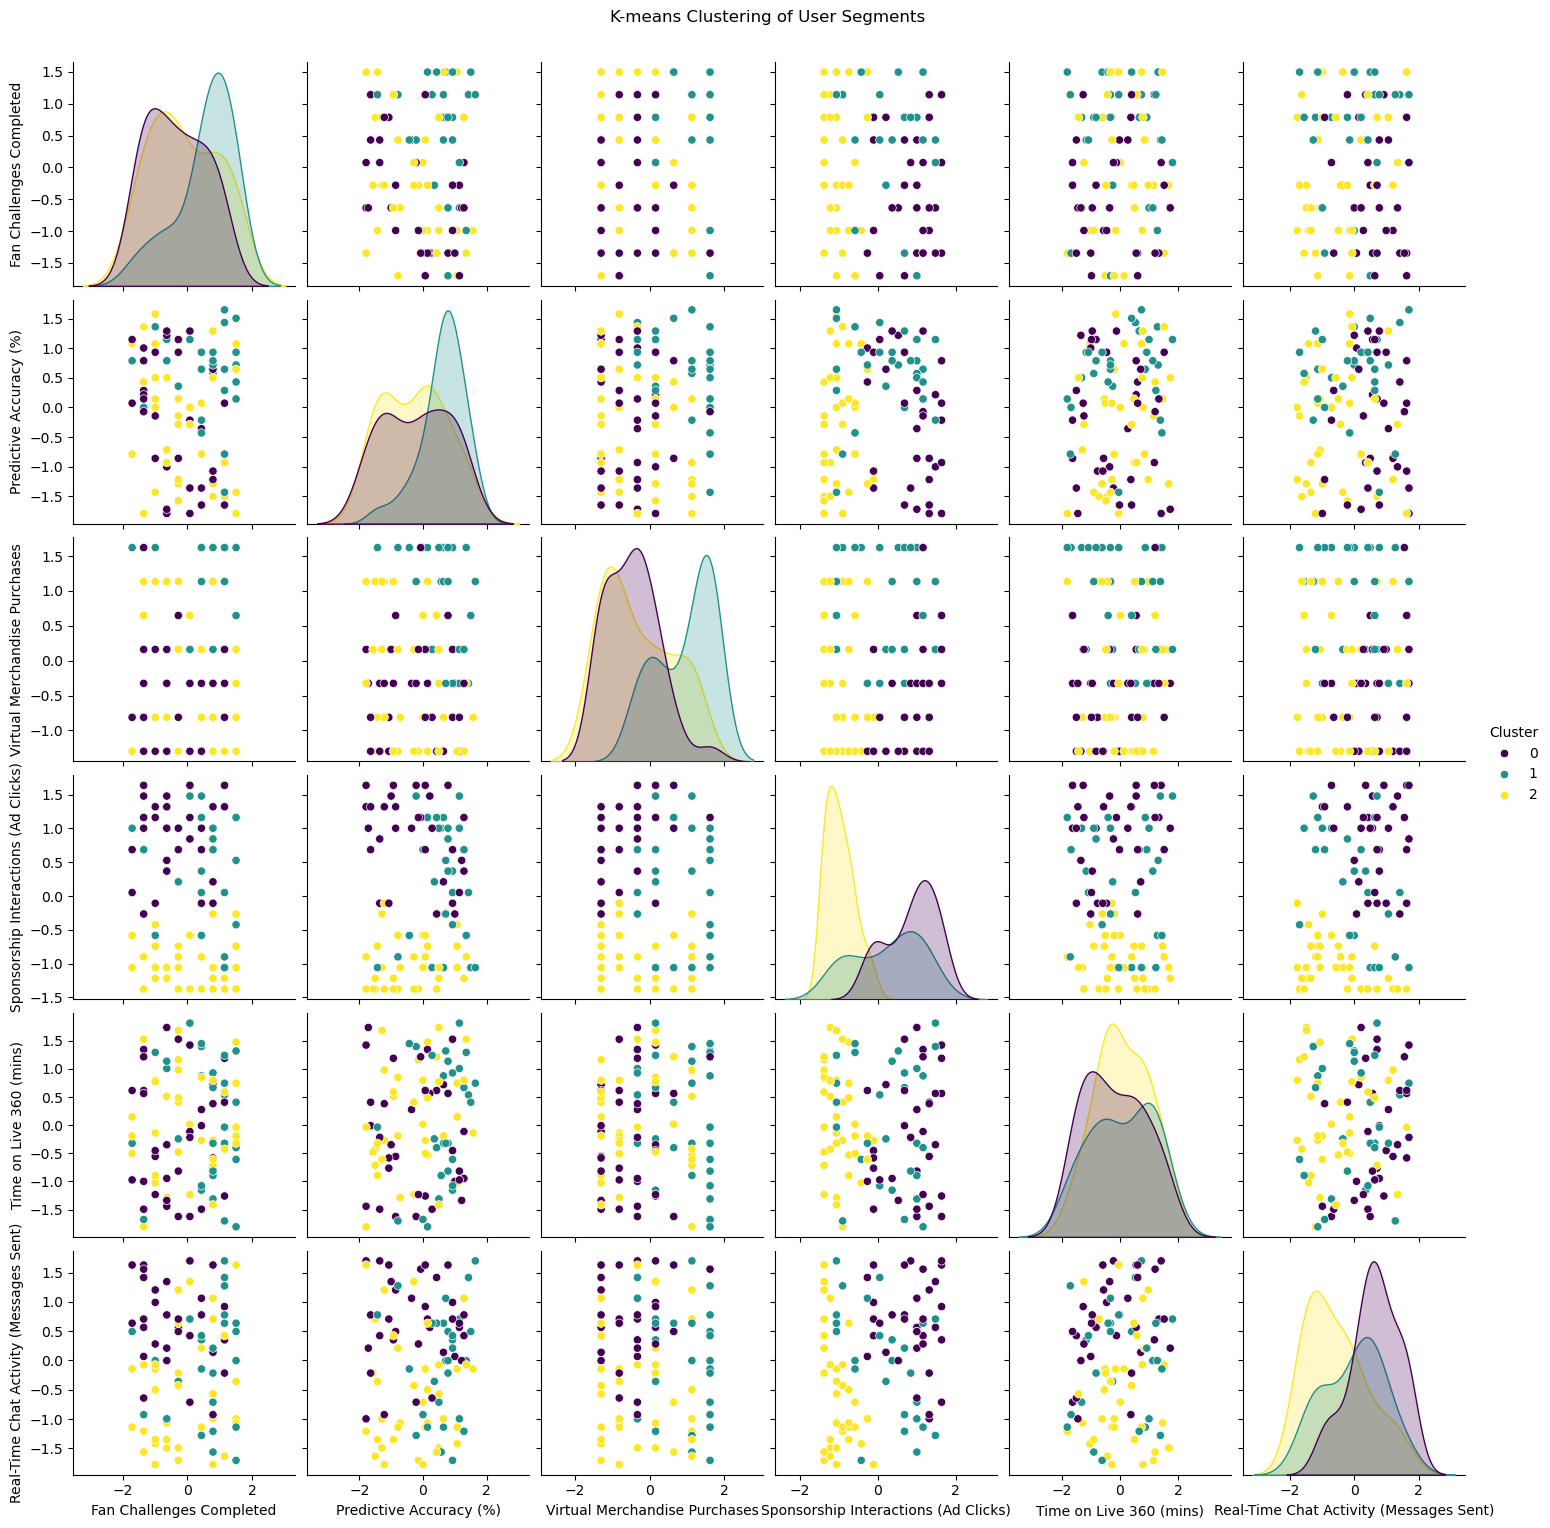

In [157]:
# Load the standardized data
file_path = 'standardized_velocityx_data.csv'
standardized_df = pd.read_csv(file_path)

# Initialize K-means with an optimal number of clusters (let's assume 3 for this example)
kmeans = KMeans(n_clusters=3, random_state=42)

# Fit the model to the data
kmeans.fit(standardized_df)

# Add the cluster labels to the original DataFrame
standardized_df['Cluster'] = kmeans.labels_

# Display the first few rows with cluster labels
print("Clustered Data:")
print(standardized_df.head())

# Save the clustered data to a new CSV file
standardized_df.to_csv('clustered_velocityx_data.csv', index=False)

# Visualize the clusters using a pairplot
sns.pairplot(standardized_df, hue='Cluster', palette='viridis')
plt.suptitle('K-means Clustering of User Segments', y=1.02)
plt.show()

Based on the observations of the clusters, here’s a detailed breakdown of the behaviors and characteristics of each cluster, focusing on key engagement metrics:<p>
**1.Cluster 0 (Purple) - Socially Engaged Users with Moderate Monetization:**<p>
* **Real-Time Chat Activity:** Cluster 1 users show the highest level of engagement in real-time chat, suggesting they are highly social and likely participate actively during live events.
* **Ad Clicks:** Their ad engagement is higher than the other two clusters, indicating they are responsive to sponsorships and could be a significant source of ad revenue.
* **Implications:**
>* **Social-Driven Monetization:** Socially interactive features such as live event chats or discussion forums could be expanded or linked to sponsorships, offering rewards or exclusive content for active participation.
>* **Ad-Supported Content:** Because of their responsiveness to ads, these users could be presented with ad-supported content or sponsored features within the chat environment to increase ad revenue. They may also be good candidates for campaigns that combine social interaction with promotional offers.

**2.Cluster 1 (Teal) - Competitive and Engaged Users:**
* **Challenge Participation and Predictive Accuracy:** This cluster has the highest involvement in challenges and demonstrates above-average predictive accuracy. These behaviors indicate a strong interest in competitive features.
* **Purchasing Behavior:** They also show high engagement with virtual merchandise purchases, suggesting they are willing to spend, possibly because they perceive the purchases as beneficial for their competitive pursuits.
* **Implications:**
>* **Monetization through Competition:** This group could be offered exclusive or advanced challenges, perhaps with rewards tied to merchandise purchases or higher predictive accuracy. They might also respond well to leaderboards, badges, or achievement-based rewards.
>* **Targeted Sponsorships:** Since they are willing to spend, premium ads or sponsorships related to their competitive interests (e.g., exclusive gear, advanced features) could be targeted at them to drive ad revenue.


**3. Cluster 2 (Yellow) - Low Engagement (General Users):** <p>
* **Ad Clicks and Purchases:** Users in this cluster exhibit low engagement in terms of ad clicks and merchandise purchases, both of which are noticeably below average. This suggests that they are likely passive consumers who are not inclined to spend or interact with monetized features.
* **Implications:**
>* **Conversion Opportunities:** These users may need more incentives or introductory offers to encourage ad engagement or purchasing. Since they are the least engaged financially, they could be a target for entry-level campaigns or free trials for premium content.
>* **Engagement Boost:** Increasing their participation in more active elements, like challenges or live chat, could potentially lead to greater monetization opportunities if they are drawn further into the app’s ecosystem.

**Summary:**
* For **Cluster 0**: Offer premium content, advanced challenges, and achievements to capitalize on their competitive nature.
* For **Cluster 1**: Utilize their social engagement by linking ads with chat features and exploring community-driven sponsorships.
* For **Cluster 2**: Focus on entry-level monetization strategies with low barriers to engagement, such as discounts or small purchases.

## 7. Predict Virtual Merchandise Purchases and Sponsorship Interactions (Ad Clicks)

1. Predictive Model for Virtual Merchandise Purchases

In [185]:
# Load the data (assumed to be standardized and prepared)
data = pd.read_csv('standardized_velocityx_data.csv')

# Define the target variable and features
data['purchase_likelihood'] = (data['Virtual Merchandise Purchases'] > 0).astype(int)  # Binary target variable
X = data.drop(columns=[ 'Virtual Merchandise Purchases', 'purchase_likelihood'])
y = data['purchase_likelihood']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_rf_model = grid_search.best_estimator_

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.71      0.59        14
           1       0.60      0.38      0.46        16

    accuracy                           0.53        30
   macro avg       0.55      0.54      0.52        30
weighted avg       0.55      0.53      0.52        30

ROC AUC Score: 0.6518


The score of 0.6518 suggests the model is slightly better than random at distinguishing between the two classes.<br>
Use the code provided below to predict purchasing behavior, enabling targeted discount offers to customers identified as more likely to make purchases.

In [ ]:
# Apply the model to new data and segment users with high purchase likelihood
user_data = pd.read_csv('user_data.csv')
user_data_prepared = scaler.transform(user_data.drop(columns=['User ID']))
purchase_likelihood = best_rf_model.predict_proba(user_data_prepared)[:, 1]
user_data['purchase_likelihood'] = purchase_likelihood
high_likelihood_users = user_data[user_data['purchase_likelihood'] > 0.7]  # Threshold for high likelihood


2. Predictive Model for Sponsorship Interactions (Ad Clicks)

In [197]:
# Define the target variable and features
data['adclick_likelihood'] = (data['Sponsorship Interactions (Ad Clicks)'] > 0).astype(int)  # Binary target variable
X = data.drop(columns=[ 'Sponsorship Interactions (Ad Clicks)', 'adclick_likelihood'])
y = data['adclick_likelihood']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Hyperparameter tuning with Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model from Grid Search
best_rf_model = grid_search.best_estimator_

# Make predictions and evaluate the model
y_pred = best_rf_model.predict(X_test)
y_pred_proba = best_rf_model.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        18
           1       0.92      1.00      0.96        12

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

ROC AUC Score: 1.0000


Since the model demonstrates strong predictive results, we can use the code provided below to forecast ad click behavior and offer rewards, such as shopping discounts or bonus points, to those identified as likely to engage.

In [ ]:
# Apply the model to new data and segment users with high ad click likelihood
user_data = pd.read_csv('user_data.csv')
user_data_prepared = scaler.transform(user_data.drop(columns=['User ID']))
purchase_likelihood = best_rf_model.predict_proba(user_data_prepared)[:, 1]
user_data['adclick_likelihood'] = purchase_likelihood
high_likelihood_users = user_data[user_data['adclick_likelihood'] > 0.7]  # Threshold for high likelihood